In [276]:
import os
from dotenv import load_dotenv
from mt5linux import MetaTrader5 
from datetime import datetime, timedelta
import pandas as pd
from matplotlib import pyplot as plt

In [277]:
MINIMUM_DATA_POINTS = 100
TIME_FRAME_VALUE = "D"
TIME_FRAME = MetaTrader5.TIMEFRAME_D1
FORCAST_HORIZON = 1
#['forex majors', 'forex crosses', 'cfd-shares usa', 'cfd-etfs usa', 'cfd-bonds', 'cfd-indices', 'forex minors', 'forex ils', 'forex rub', 'forex try', 'forex zar', 'cfd-crypto', 'cfd-energies', 'cfd-agricultural', 'cfd-metals', 'internal', 'cfd-shares france', 'cfd-shares uk', 'cfd-shares germany', 'cfd-shares italy', 'cfd-shares canada', 'cfd-shares dutch']
CATEGORY = "cfd-metals"
START_DAYS_AGO = 365  # 2 years

RSI_WINDOW = 14

In [278]:
list_of_momentums = [1,2]

In [ ]:


FOREX_CATEGORIES = {}

class MetatraderSocket:
    
    open_trades = {}
   
    
    def __init__(self):
        """Initialize the connections tpytho MT5, SQL
        """
        
                # connecto to the server
        self.mt5 = MetaTrader5(
            host = os.getenv("MT5_SERVER"),
            port = os.getenv("MT5_PORT")
        ) 
        # self.mt5.execute('!pip3 install --upgrade numpy')
        self.mt5.execute('import datetime')
        account_id = int(os.getenv('ACCOUNT_NO')) # Replace with your account number
        # print(type(account_id))
        password = os.getenv("PASS") # Replace with your password
        server = os.getenv("METATRADER_BROKER_SERVER") # Replace with your broker's server

        # use as you learned from: https://www.mql5.com/en/docs/integration/python_metatrader5/
        if not self.mt5.initialize(login=account_id,password=password,server=server):
           print("initialize() failed, error code =",self.mt5.last_error())
           print("Problem connecting to Metatrader5" + str(self.mt5.last_error()))
        self.mt5.terminal_info()
        self.set_categories()
        
    def set_categories(self):
        """Set the categories of the symbols : Forex Major, Forex Minor, Forex Exotic, Crypto, Indices, Commodities
        """
        for item in self.mt5.symbols_get():
            category = " ".join(item.path.split("\\")[:-1]).lower()
            symbol = item.path.split("\\")[-1]
            print("Category: " + str(category) + " Symbol: " + str(symbol))
            if category not in list(FOREX_CATEGORIES.keys()):
                FOREX_CATEGORIES[category] = []
            FOREX_CATEGORIES[category].append(symbol)
        print("Categories set: " + str(FOREX_CATEGORIES.keys()))
    
    def get_category_historical_data(self,category = "Forex Majors", start_date=datetime.now() - timedelta(days=5),end_date=datetime.now()):
        """
        Get historical data for a specific category of Forex symbols.
        This function retrieves historical data for all symbols in a specified category, such as "Forex Major", "Forex Minor", etc.

        Args:
            category (str, optional): _description_. Defaults to "Forex Major".
            start_date (_type_, optional): _description_. Defaults to datetime.now()-timedelta(days=365*5).
            end_date (_type_, optional): _description_. Defaults to datetime.now().

        Returns:
            _type_: _description_
        """
        # Get the 
        combined_historical_data = pd.DataFrame()

        currencies = FOREX_CATEGORIES[category.lower()]
        # Filter the companies to exclude those with '.B'
        for currency in currencies:
            rates = self.mt5.copy_rates_range(currency, TIME_FRAME,start_date,end_date)
            if rates is None:
                print(f"Warning: No data for {currency}")
                continue
            historical_data = pd.DataFrame(rates)
            historical_data['time'] = pd.to_datetime(historical_data['time'], unit='s')
            historical_data.set_index('time', inplace=True)
            # Rename 'close' column to the currency name
            df = historical_data[['close']].rename(columns={'close': currency})
            # Merge into combined DataFrame
            if combined_historical_data.empty:
                combined_historical_data = df
            else:
                combined_historical_data = combined_historical_data.join(df, how='outer') 
        print(f"Retrieved historical data for {len(currencies)} symbols in category '{category}'")
        print(f"Combined historical data shape: {combined_historical_data.shape}")
        print(combined_historical_data.head())

        return combined_historical_data.loc[:, combined_historical_data.count() >= MINIMUM_DATA_POINTS]

    def computing_returns(self,historical_data, list_of_momentums):
        """
        Compute returns for the historical data based on specified momentums.

        Args:
            historical_data (pd.DataFrame): DataFrame containing historical data with currency symbols as columns.
            list_of_momentums (list): List of momentum periods to compute returns for.

        Returns:
            pd.DataFrame: DataFrame containing returns for each currency and each momentum period.
        """
        f_returns = historical_data.pct_change(periods=FORCAST_HORIZON)
        f_returns = f_returns.shift(-FORCAST_HORIZON)
        f_returns = pd.DataFrame(f_returns.unstack())
        name = "F_" + str(FORCAST_HORIZON) + "_" + TIME_FRAME_VALUE + "_returns"
        f_returns.rename(columns={0: name}, inplace=True)
        total_returns = f_returns
        returns = pd.DataFrame(index=historical_data.index)
        for momentum in list_of_momentums:
            feature = historical_data.pct_change(periods=momentum)
            feature = pd.DataFrame(feature.unstack())
            name = str(momentum) + "_"+TIME_FRAME_VALUE+"_returns"
            feature.rename(columns={0: name,"level_0":"Ticker"}, inplace=True)
            total_returns = pd.merge(total_returns, feature, left_index=True, right_index=True, how='outer')
        total_returns.dropna(axis=0, how='any',inplace=True)
        return total_returns
    
    def compute_BM_Perf(self,total_returns,category):
        """
        Compute the cummulative returns, CAGR, Sharpe Ratio, and calendar returns for a given category based on the total returns DataFrame.

        Args:
            total_returns (pd.DataFrame): DataFrame containing returns for each currency and each momentum period.

        Returns:
            pd.DataFrame: DataFrame containing the benchmark performance.
        """
 
        daily_mean = pd.DataFrame(total_returns.loc[:,f"F_{FORCAST_HORIZON}_{TIME_FRAME_VALUE}_returns"].groupby(level='time').mean())
        daily_mean.rename(columns = {f"F_{FORCAST_HORIZON}_{TIME_FRAME_VALUE}_returns": CATEGORY}, inplace=True)

        
        #Convert Daily returns to cummulative returns
        #Cumulative return is the total return an investment has generated from a starting point to an end point — compounding all gains/losses over time. Formula:
        cum_returns = pd.DataFrame((daily_mean[[category]] + 1).cumprod())
        cum_returns.plot()
        plt.title(f"Cumulative Returns of {category} Over time",fontsize=16, fontweight='bold')
        plt.xlabel("Date")
        plt.ylabel("Cumulative Returns")
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.legend(fontsize='11',title_fontsize='13')
        plt.show()

        # Calulcate the number of years in the dataset
        number_of_years = len(daily_mean) /252
        ending_value    = cum_returns[category].iloc[-1]
        beginning_value = cum_returns[category].iloc[1]

        # Compute the compound Annual Growth Rate(GAGR) - 
        # CAGR is the average annual growth rate of an investment over a period of time, assuming the profits are compounded each year.
        # It answers the question: "If my investment grew at a steady rate each year, what would that rate be?"
        ratio = ending_value / beginning_value
        cagr = round((ratio ** (1/number_of_years)-1)*100,2)
        print(f'The CAGR is {cagr}% over {number_of_years} years for {category}.')
        
            
        # Compute the Sharpe Ratio(extra return per unit risk) by annualizing the daily mean and the daily std
        average_daily_return = daily_mean[[category]].describe().iloc[1,:] *252
        stand_dev_daily_return = daily_mean[[category]].describe().iloc[2,:] * pow(252,1/2)

        # average_daily_return = daily_mean[[category]].describe()
        sharpe  = average_daily_return/stand_dev_daily_return

        print(f'Sharpe Ratio of Strategy: {round(sharpe.iloc[0],2)}')
        
        #Calendar returns show the return for a specific calendar period, like a month, quarter, or year — treating each as a separate unit.
        ann_returns = (pd.DataFrame((daily_mean[[category]]+1).groupby(daily_mean.index.get_level_values(0).year).cumprod())-1)*100
        calendar_returns  = pd.DataFrame(ann_returns[category].groupby(daily_mean.index.get_level_values(0).year).last())

        calendar_returns.plot.bar(rot=30,  legend='top_left')#.opts(multi_level=False) 

        return cum_returns, calendar_returns

    def calculate_rsi(returns, RSI_WINDOW=14):
        """
        Calculate the Relative Strength Index (RSI) for the given total returns DataFrame.

        Args:
            total_returns (pd.DataFrame): DataFrame containing returns for each currency and each momentum period.
            RSI_WINDOW (int): The window size for calculating RSI.

        Returns:
            pd.DataFrame: DataFrame with RSI values added.
        """
        
        gain = returns[returns>0].dropna().rolling(window=RSI_WINDOW).mean()
        gain.name = "Gain"
        loss = returns[returns<0].dropna().rolling(window=RSI_WINDOW).mean()
        loss.name = "Loss"
        returns = pd.merge(returns, gain, left_index=True, right_index=True, how='left')
        returns = pd.merge(returns, loss, left_index=True, right_index=True, how='left')
        returns = returns.ffill()
        returns.dropna(inplace=True)
        ratio = returns['Gain']/abs(returns['Loss'])
        rsi = 100 - (100 / (1 + ratio))
        return rsi
    


In [280]:
socket = MetatraderSocket()

Category: forex majors Symbol: EURUSD
Category: forex majors Symbol: GBPUSD
Category: forex majors Symbol: USDCHF
Category: forex majors Symbol: USDJPY
Category: forex majors Symbol: USDCAD
Category: forex majors Symbol: AUDUSD
Category: forex crosses Symbol: AUDCAD
Category: forex crosses Symbol: AUDNZD
Category: forex crosses Symbol: AUDCHF
Category: forex crosses Symbol: AUDJPY
Category: forex crosses Symbol: CHFJPY
Category: forex majors Symbol: EURGBP
Category: forex crosses Symbol: EURAUD
Category: forex majors Symbol: EURCHF
Category: forex majors Symbol: EURJPY
Category: forex crosses Symbol: EURNZD
Category: forex crosses Symbol: EURCAD
Category: forex crosses Symbol: GBPCHF
Category: forex majors Symbol: GBPJPY
Category: forex crosses Symbol: CADCHF
Category: cfd-shares usa Symbol: #ALIBABA
Category: cfd-shares usa Symbol: #AMAZON
Category: cfd-shares usa Symbol: #AMERICAN_E
Category: cfd-shares usa Symbol: #APPLE
Category: cfd-shares usa Symbol: #AT&T
Category: cfd-shares us

Retrieved historical data for 6 symbols in category 'cfd-metals'
Combined historical data shape: (312, 6)
            COPPER     GOLD  PALLADIUM  PLATINUM  SILVER  SI_SEP24
time                                                              
2024-06-02  4.6300  2325.82      920.7    1045.1  30.387    30.866
2024-06-03  4.6805  2350.52      934.7    1026.3  30.730    31.198
2024-06-04  4.5500  2328.73      922.2     997.0  29.563    30.003
2024-06-05  4.6195  2355.01      939.2    1002.9  29.999    30.436
2024-06-06  4.6680  2376.78      937.7    1012.7  31.324    31.773


/tmp/ipykernel_3433396/3157561968.py:93: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  f_returns = historical_data.pct_change(periods=FORCAST_HORIZON)
/tmp/ipykernel_3433396/3157561968.py:101: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  feature = historical_data.pct_change(periods=momentum)
/tmp/ipykernel_3433396/3157561968.py:101: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  feature = hi

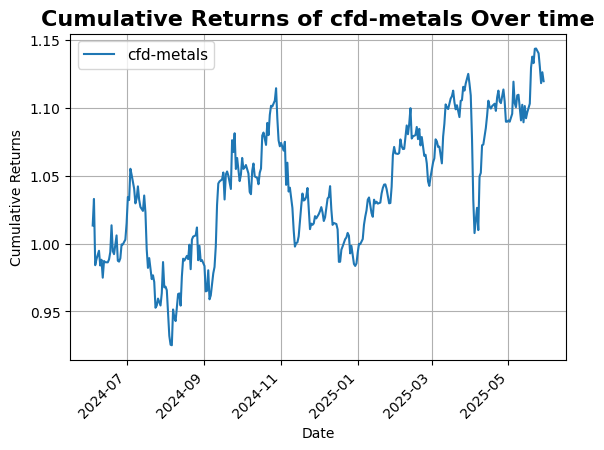

The CAGR is 6.8% over 1.2261904761904763 years for cfd-metals.
Sharpe Ratio of Strategy: 0.59


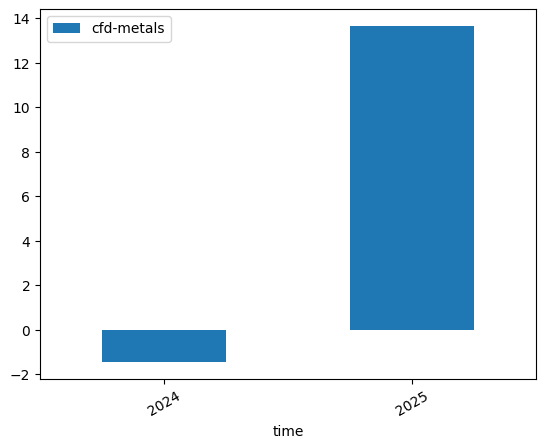

In [281]:
historical_data = socket.get_category_historical_data(category=CATEGORY, start_date=datetime.now() - timedelta(days=START_DAYS_AGO), end_date=datetime.now())
returns = socket.computing_returns(historical_data, list_of_momentums)
cumm, calender = socket.compute_BM_Perf(returns, CATEGORY)

In [282]:

f_returns = historical_data.pct_change(periods=FORCAST_HORIZON)
f_returns = f_returns.shift(-FORCAST_HORIZON)
print(f_returns.head())
print(f_returns.unstack())
f_returns = pd.DataFrame(f_returns.unstack())
print(f_returns.head())
name = "F_" + str(FORCAST_HORIZON) + "_" + TIME_FRAME_VALUE + "_returns"
print(f_returns.columns)
f_returns.rename(columns={0: name}, inplace=True)
f_returns.head()
total_returns = f_returns

              COPPER      GOLD  PALLADIUM  PLATINUM    SILVER  SI_SEP24
time                                                                   
2024-06-02  0.010907  0.010620   0.015206 -0.017989  0.011288  0.010756
2024-06-03 -0.027882 -0.009270  -0.013373 -0.028549 -0.037976 -0.038304
2024-06-04  0.015275  0.011285   0.018434  0.005918  0.014748  0.014432
2024-06-05  0.010499  0.009244  -0.001597  0.009772  0.044168  0.043928
2024-06-06 -0.047451 -0.034917  -0.020262 -0.042658 -0.069148 -0.069241
          time      
COPPER    2024-06-02    0.010907
          2024-06-03   -0.027882
          2024-06-04    0.015275
          2024-06-05    0.010499
          2024-06-06   -0.047451
                          ...   
SI_SEP24  2025-05-26    0.000000
          2025-05-27    0.000000
          2025-05-28    0.000000
          2025-05-29    0.000000
          2025-05-30         NaN
Length: 1872, dtype: float64
                          0
       time                
COPPER 2024-06-02  0.010907

/tmp/ipykernel_3433396/1091077338.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  f_returns = historical_data.pct_change(periods=FORCAST_HORIZON)


In [283]:

for momentum in list_of_momentums:
    feature = historical_data.pct_change(periods=momentum)
    feature = pd.DataFrame(feature.unstack())
    name = str(momentum) + f"_{TIME_FRAME_VALUE}_returns"
    feature.rename(columns={0: name,"level_0":"Ticker"}, inplace=True)
    total_returns = pd.merge(total_returns, feature, left_index=True, right_index=True, how='outer')
    
total_returns.dropna(axis=0, how='any',inplace=True)

/tmp/ipykernel_3433396/972937582.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  feature = historical_data.pct_change(periods=momentum)
/tmp/ipykernel_3433396/972937582.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  feature = historical_data.pct_change(periods=momentum)


In [284]:
total_returns

F_1_D_returns  1_D_returns  2_D_returns
         time                                               
COPPER   2024-06-04       0.015275    -0.027882    -0.017279
         2024-06-05       0.010499     0.015275    -0.013033
         2024-06-06      -0.047451     0.010499     0.025934
         2024-06-07       0.002699    -0.047451    -0.037450
         2024-06-09       0.019177     0.002699    -0.044880
...                            ...          ...          ...
SI_SEP24 2025-05-25       0.000000     0.000000     0.000000
         2025-05-26       0.000000     0.000000     0.000000
         2025-05-27       0.000000     0.000000     0.000000
         2025-05-28       0.000000     0.000000     0.000000
         2025-05-29       0.000000     0.000000     0.000000

[1854 rows x 3 columns]

In [285]:
daily_mean = pd.DataFrame()
total_returns.head()


F_1_D_returns  1_D_returns  2_D_returns
       time                                               
COPPER 2024-06-04       0.015275    -0.027882    -0.017279
       2024-06-05       0.010499     0.015275    -0.013033
       2024-06-06      -0.047451     0.010499     0.025934
       2024-06-07       0.002699    -0.047451    -0.037450
       2024-06-09       0.019177     0.002699    -0.044880

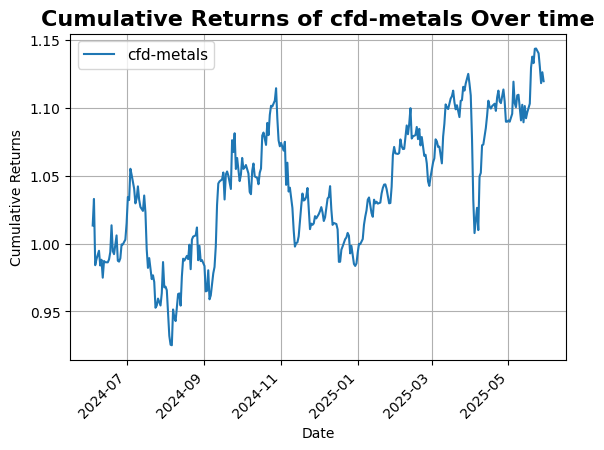

The CAGR is 6.8% over 1.2261904761904763 years for cfd-metals category.


In [286]:
daily_mean = pd.DataFrame(total_returns.loc[:,f"F_{FORCAST_HORIZON}_{TIME_FRAME_VALUE}_returns"].groupby(level='time').mean())
daily_mean.rename(columns = {f"F_{FORCAST_HORIZON}_{TIME_FRAME_VALUE}_returns": CATEGORY}, inplace=True)


#Convert Daily returns to cummulative returns
cum_returns = pd.DataFrame((daily_mean[[CATEGORY]] + 1).cumprod())
cum_returns.plot()
plt.title(f"Cumulative Returns of {CATEGORY} Over time",fontsize=16, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(fontsize='11',title_fontsize='13')
plt.show()

# Calulcate the number of years in the dataset
number_of_years = len(daily_mean) /252
ending_value    = cum_returns[CATEGORY].iloc[-1]
beginning_value = cum_returns[CATEGORY].iloc[1]

# Compute the compound Annual Growth Rate(GAGR)
ratio = ending_value / beginning_value
cagr = round((ratio ** (1/number_of_years)-1)*100,2)
print(f'The CAGR is {cagr}% over {number_of_years} years for {CATEGORY} category.')


In [287]:
    
# Compute the Sharpe Ratio(extra return per unit risk) by annualizing the daily mean and the daily std
average_daily_return = daily_mean[[CATEGORY]].describe().iloc[1,:] *252
stand_dev_daily_return = daily_mean[[CATEGORY]].describe().iloc[2,:] * pow(252,1/2)

# average_daily_return = daily_mean[[CATEGORY]].describe()
sharpe  = average_daily_return/stand_dev_daily_return

print(f'Sharpe Ratio of Strategy: {round(sharpe.iloc[0],2)}')

Sharpe Ratio of Strategy: 0.59


<Axes: xlabel='time'>

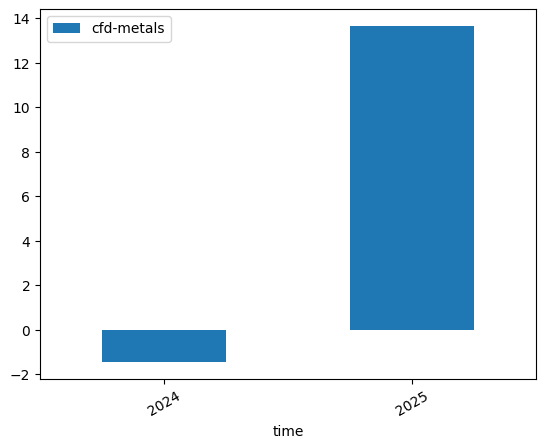

In [288]:
ann_returns = (pd.DataFrame((daily_mean[[CATEGORY]]+1).groupby(daily_mean.index.get_level_values(0).year).cumprod())-1)*100
calendar_returns  = pd.DataFrame(ann_returns[CATEGORY].groupby(daily_mean.index.get_level_values(0).year).last())

calendar_returns.plot.bar(rot=30,  legend='top_left')#.opts(multi_level=False) 

In [289]:
def calculate_rsi(returns, RSI_WINDOW=RSI_WINDOW):
    """
    Calculate the Relative Strength Index (RSI) for the given total returns DataFrame.

    Args:
        total_returns (pd.DataFrame): DataFrame containing returns for each currency and each momentum period.
        RSI_WINDOW (int): The window size for calculating RSI.

    Returns:
        pd.DataFrame: DataFrame with RSI values added.
    """
    
    gain = returns[returns>0].dropna().rolling(window=RSI_WINDOW).mean()
    gain.name = "Gain"
    loss = returns[returns<0].dropna().rolling(window=RSI_WINDOW).mean()
    loss.name = "Loss"
    returns = pd.merge(returns, gain, left_index=True, right_index=True, how='left')
    returns = pd.merge(returns, loss, left_index=True, right_index=True, how='left')
    returns = returns.ffill()
    returns.dropna(inplace=True)
    ratio = returns['Gain']/abs(returns['Loss'])
    rsi = 100 - (100 / (1 + ratio))
    return rsi

In [292]:
print(total_returns.index.names)
print(total_returns.index.get_level_values(0))

## Calculate the Relative Strength Index (RSI) for each 'Ticker' and add it to the 'total_returns' DataFrame. First, group the 'total_returns' DataFrame by the 'Ticker' column.
# For each group, select the '1_d_returns' column and apply a transformation using the 'calculate_rsi' function from 'func_lib'.
# - Assign the result to a new column named 'RSI' in the 'total_returns' DataFrame.
total_returns.index.rename("Ticker", level=0, inplace=True)
total_returns.groupby('Ticker')[['1_D_returns']].transform(calculate_rsi)

[None, 'time']
Index(['COPPER', 'COPPER', 'COPPER', 'COPPER', 'COPPER', 'COPPER', 'COPPER',
       'COPPER', 'COPPER', 'COPPER',
       ...
       'SI_SEP24', 'SI_SEP24', 'SI_SEP24', 'SI_SEP24', 'SI_SEP24', 'SI_SEP24',
       'SI_SEP24', 'SI_SEP24', 'SI_SEP24', 'SI_SEP24'],
      dtype='object', length=1854)


1_D_returns
Ticker   time                   
COPPER   2024-06-04          NaN
         2024-06-05          NaN
         2024-06-06          NaN
         2024-06-07          NaN
         2024-06-09          NaN
...                          ...
SI_SEP24 2025-05-25    46.443159
         2025-05-26    46.443159
         2025-05-27    46.443159
         2025-05-28    46.443159
         2025-05-29    46.443159

[1854 rows x 1 columns]